<a href="https://colab.research.google.com/github/remigiuszk/machine-learning-175ic-kaminski/blob/main/Zadanie3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import plotly.express as px

np.random.seed(10)

df_raw = pd.read_csv("https://storage.googleapis.com/esmartdata-courses-files/ml-course/insurance.csv")
df_raw.head()

df = df_raw.copy()

#usuniecie duplikatow i NaN
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)


usuniecie duplikatow i NaN

In [9]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


zmiana typu danych na kategorie kolumn plec, palący i region

In [11]:
for col in ['sex','smoker','region']:
    df[col] = df[col].astype('category')

wykres

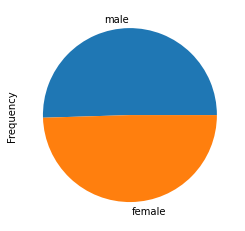

In [17]:
df.sex.value_counts().plot(kind='pie')
df.smoker.value_counts()
df.charges.plot(kind='hist',bins=30)
px.histogram(df,x='charges', width=700,height=400,nbins=50,facet_col='smoker',facet_row='sex')

korelacje

In [18]:
df_dummies = pd.get_dummies(df,drop_first=True)

corr = df_dummies.corr()
corr

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109344,0.041536,0.298308,-0.019814,-0.025587,0.001495,-0.012311,0.009415
bmi,0.109344,1.000000,0.012755,0.198401,0.046397,0.003746,-0.136138,0.270057,-0.006211
children,0.041536,0.012755,1.000000,0.067389,0.017848,0.007331,0.026044,-0.023492,0.021538
charges,0.298308,0.198401,0.067389,1.000000,0.058044,0.787234,-0.038695,0.073578,-0.043637
sex_male,-0.019814,0.046397,0.017848,0.058044,1.000000,0.076596,-0.012482,0.017578,-0.003767
smoker_yes,-0.025587,0.003746,0.007331,0.787234,0.076596,1.000000,-0.036321,0.068282,-0.037168
region_northwest,0.001495,-0.136138,0.026044,-0.038695,-0.012482,-0.036321,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270057,-0.023492,0.073578,0.017578,0.068282,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006211,0.021538,-0.043637,-0.003767,-0.037168,-0.320493,-0.346614,1.000000


mapa ciepła

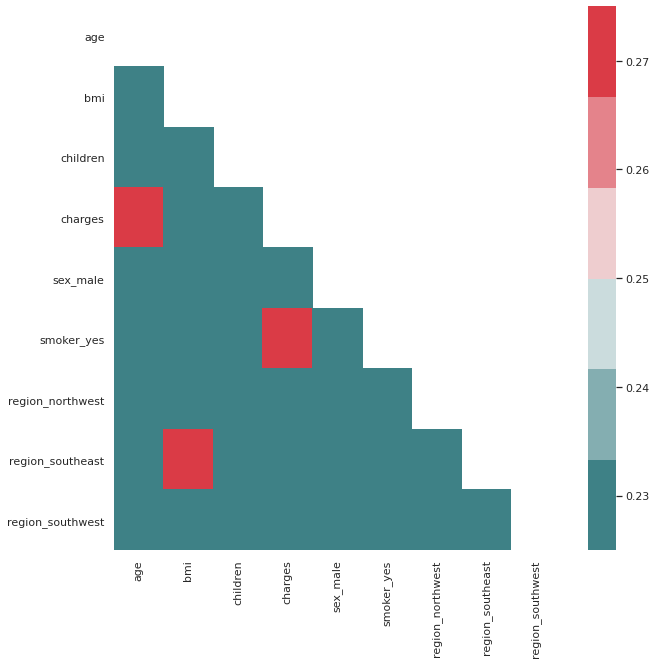

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1
plt.subplots(figsize=(10,10))
cmap =sns.diverging_palette(200,10)
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=0.25,vmin=0.25)

Dane jako liczby

In [20]:
df_dummies.corr()['charges'].sort_values(ascending=False)

charges             1.000000
smoker_yes          0.787234
age                 0.298308
bmi                 0.198401
region_southeast    0.073578
children            0.067389
sex_male            0.058044
region_northwest   -0.038695
region_southwest   -0.043637
Name: charges, dtype: float64

Dane jako wykres słupkowy

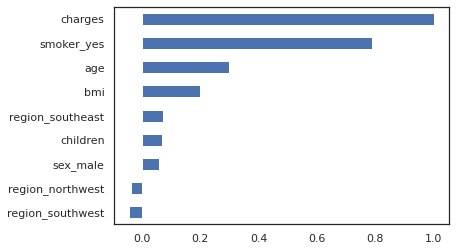

In [21]:
df_dummies.corr()['charges'].sort_values().plot(kind='barh')

Podział danych na zbior treningowy i testowy

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
df1=df_dummies['charges']
df2=df_dummies.drop(columns='charges')

X_train, X_test,y_train,y_test = train_test_split(df2,df1)


#Regresja liniowa

In [25]:
regressor = LinearRegression()
regressor.fit(X_train,y_train)
print(f'R2 score:{regressor.score(X_test,y_test):.4f}')


R2 score:0.7190


Wartośći wyliczone przez regresje

In [26]:
y_pred = regressor.predict(X_test)
y_pred[:10]

array([ 4522.91891136,  4200.46473226, 12080.41929871, 11895.75604569,
       34071.68519032,  5420.83385693, 11372.08285744,  3288.13767644,
       38318.37402816, 15748.61155676])

Błąd poszczególnych pomiarów

In [27]:
y_true =y_test.copy()
predictions=pd.DataFrame(data={'y_true':y_true, 'y_pred' :y_pred})
predictions['error'] = predictions['y_true']-predictions['y_pred']
predictions.head()

,y_true,y_pred,error
1108,2904.08800,4522.918911,-1618.830911
125,3385.39915,4200.464732,-815.065582
233,12333.82800,12080.419299,253.408701
334,19144.57652,11895.756046,7248.820474
953,38998.54600,34071.685190,4926.860810


wykres błędów

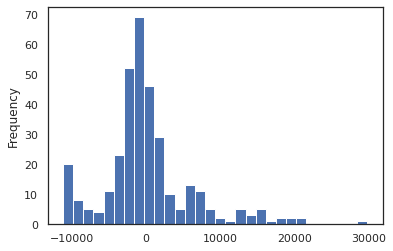

In [28]:
predictions.error.plot(kind='hist', bins=30)

Średni błąd

In [29]:
from sklearn.metrics import mean_absolute_error

mae=mean_absolute_error(y_true, y_pred)
print(f'MAE wynosi:{mae:.2f}')

MAE wynosi:4074.51


Eliminacja wsteczna

In [31]:
import statsmodels.api as sm

X_train_ols=sm.add_constant(X_train.values)
ols=sm.OLS(endog=y_train,exog=X_train_ols).fit()
predictors=['const']+list(X_train.columns)
print(ols.summary(xname=predictors))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     391.0
Date:                Tue, 01 Dec 2020   Prob (F-statistic):          1.28e-300
Time:                        20:04:17   Log-Likelihood:                -10146.
No. Observations:                1002   AIC:                         2.031e+04
Df Residuals:                     993   BIC:                         2.035e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.224e+04   1146.634  

Zadanie2.
Usunięcie kolumn nie wpłwających na wyjsćie

In [32]:
df_dummies_filtered = df_dummies.drop(columns=['sex_male','region_northwest'])
df_dummies_filtered

,age,bmi,children,charges,smoker_yes,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,1
1,18,33.770,1,1725.55230,0,1,0
2,28,33.000,3,4449.46200,0,1,0
3,33,22.705,0,21984.47061,0,0,0
4,32,28.880,0,3866.85520,0,0,0
...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0,0,0
1334,18,31.920,0,2205.98080,0,0,0
1335,18,36.850,0,1629.83350,0,1,0
1336,21,25.800,0,2007.94500,0,0,1


regresja liniowa nowej tabeli

In [34]:
df1 = df_dummies_filtered['charges']
df2 = df_dummies_filtered.drop(columns='charges')

X_train,X_test,y_train,y_test = train_test_split(df2,df1)

regressor.fit(X_train,y_train)
r2_score2=regressor.score(X_test,y_test)
print(f'R2 score:{r2_score2:.4f}')

y_pred=regressor.predict(X_test)
y_true=y_test.copy()
mae2=mean_absolute_error(y_true, y_pred)
print(f'MAE wynosi:{mae2:.2f}')

R2 score:0.7145
MAE wynosi:4503.51


Porównanie wielkości

In [38]:
from sys import getsizeof

before_size = getsizeof(df_dummies)
after_size = getsizeof(df_dummies_filtered)
difference = 100-(after_size/before_size*100)
print("Rozmiar przed usunięciem kolumn: ",before_size)
print("Rozmiar po usununięciu kolumn: ",before_size)
print(f'Różnica procentowa: {difference:.2f}%')

Rozmiar przed usunięciem kolumn:  60189
Rozmiar po usununięciu kolumn:  60189
Różnica procentowa: 4.44%


Porównanie średniego błędu oraz wartości r2

In [41]:
mae_diff=mae2-mae
print(f'MAE przed usunięciem:{mae:.4f}')
print(f'MAE po usunięciu:{mae2:.4f}')
print(f'MAE Różnica : {mae_diff:.4f}')

r2_diff = r2_score2-r2_score
print(f'R2 przed usunięciem:{r2_score:.4f}')
print(f'R2 po usunięciu:{r2_score2:.4f}')
print(f'R2 różnica: {r2_diff:.4f}')

MAE przed usunięciem:4074.5106
MAE po usunięciu:4503.5077
MAE Różnica : 428.9971
R2 przed usunięciem:0.7190
R2 po usunięciu:0.7145
R2 różnica: -0.0045
